In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels
shifts = 5

## Setting up a play dataset

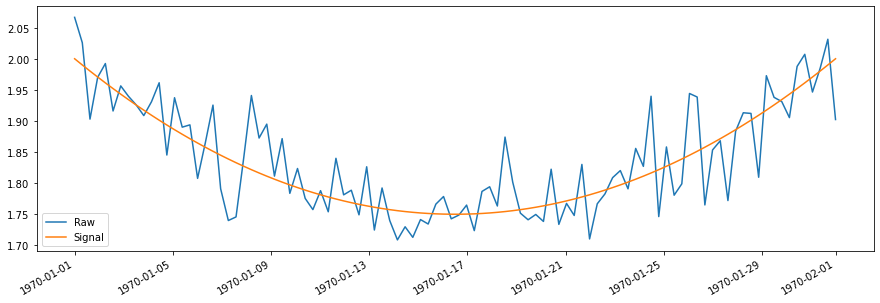

In [2]:
# Create test data
np.random.seed(10)
nx = 100
x = np.linspace(0, 10, nx)
x_dt = pd.date_range(start="1970", periods=nx, end="02-01-1970")

y_hat = 1e-2 * x ** 2 - 1e-1 * x + 2

y_tilda = np.random.normal(size=nx, scale=0.05)

y = y_hat + y_tilda

data = pd.Series(y, index=x_dt)
perfect_data = pd.Series(y_hat, index=x_dt)

data.plot(figsize=(15,5))
perfect_data.plot()
plt.legend(['Raw','Signal'])

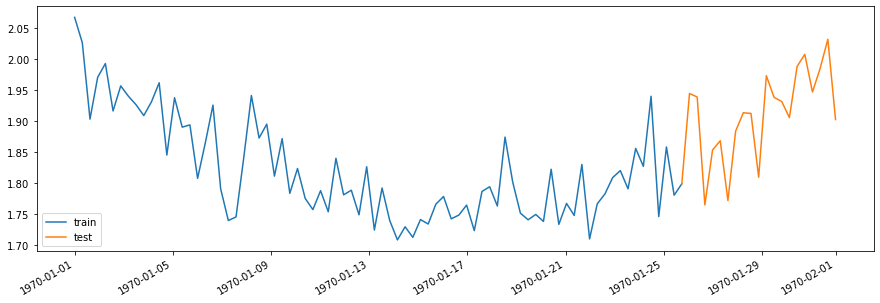

In [3]:
# Divide into training and test sets; let's take 80%
train_test_split = 0.8
n_train = int(nx*train_test_split)

train_data = data[:n_train]
test_data = data[n_train-1:]

train_data.plot(figsize=(15,5))
test_data.plot()
plt.legend(['train','test'])

In [4]:
# Defining metric
def sse(x1, x2):
    return np.sum((x1-x2)**2)

In [5]:
sse(data, perfect_data)

0.2353680891620946

# A naive model

A naive model is one that depends only on the previous timestep

0.47674834708417874

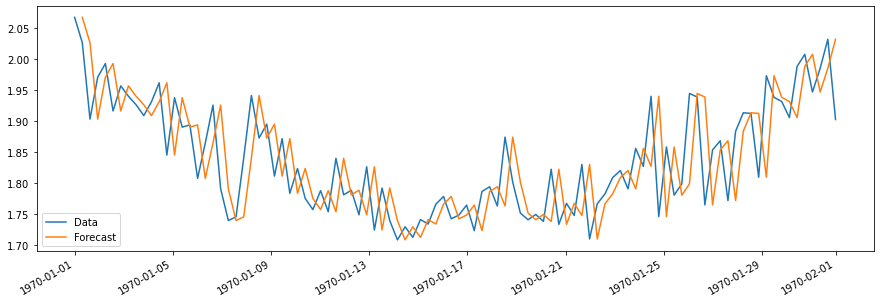

In [10]:
# Naive model 
def naive_model(x):
    return x[0]
    
res = data.shift().rolling(1).apply(naive_model)
# One step ahead forecast
data.plot()
res.plot(figsize=(15,5))
plt.legend(['Data','Forecast'])

sse(data, res)


0.5870683840142547

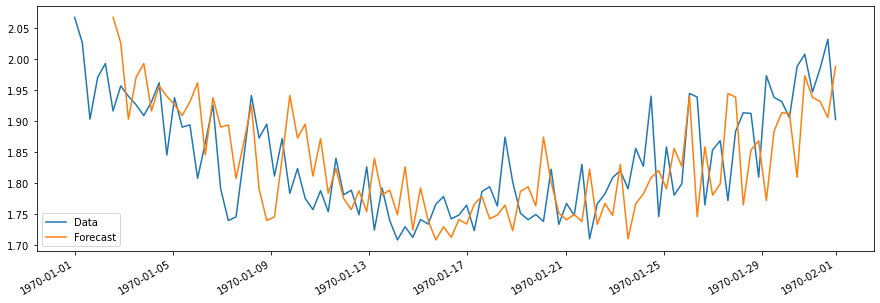

In [11]:
# 5 steps ahead forecast
data.plot()
data.shift().rolling(5).apply(naive_model).plot(figsize=(15,5))
plt.legend(['Data','Forecast'])
sse(data, data.rolling(6).apply(naive_model))


0.6432189819365957

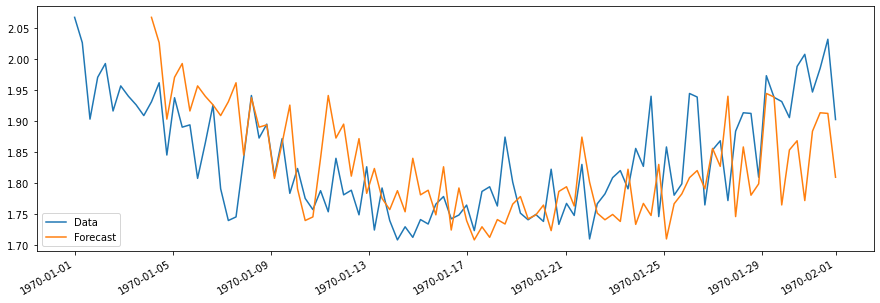

In [12]:
# 10 steps ahead forecast
data.plot()
data.shift().rolling(10).apply(naive_model).plot(figsize=(15,5))
plt.legend(['Data','Forecast'])
sse(data, data.rolling(10).apply(naive_model))


## Moving window models

Performs a weighted sum of all observations in a chosen rolling window. The weights can be defined using the following methods:

* Simple moving average: each observation in the window has an equal weight (i.e. weight is 1/n). 

* Linear weighted moving average:  The weights decrease linearly over the entire moving window such that the sum of all weights is equal to 1 with the most recent observations in the window having the largest weights. 

* Exponential moving average: The weights decrease exponentially as specified by the user-defined alpha and half-life parameters with the most recent observations in the window having the largest weights. 

* Arnaud Legoux (ALMA smoother) : typically used in the financial industry which aims to strike a good balance between smoothness and responsiveness (i.e. capture a general smoothed trend without allowing for significant lag). The weights follow a Gaussian distribution with an offset where the offset and spread of the distribution are user defined.

0.4013083568574099

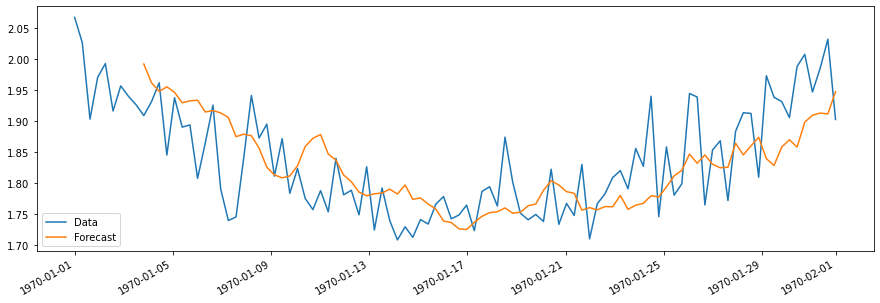

In [13]:
# Simple moving average model
def sma(x):
    return x.mean()

res_sma = data.shift(shifts).rolling(5).apply(sma)
# Using 5 steps forecast
data.plot()
res_sma.plot(figsize=(15,5))
plt.legend(['Data','Forecast'])

sse(data, res_sma)


Linear Weighted Average

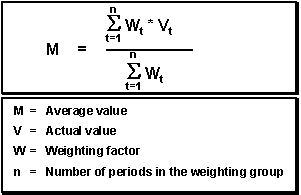

0.3930693658764428

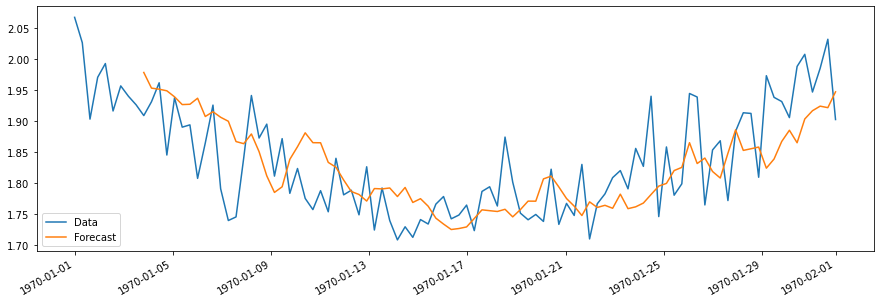

In [14]:
# Linear weighted moving average
def lwa(x):
    weights = np.arange(1, len(x) + 1)
    wma_val = np.dot(x, weights) / weights.sum()
    return wma_val

res_lwa = data.shift(shifts).rolling(5).apply(lwa)

# Using 5 steps forecast
data.plot()
res_lwa.plot(figsize=(15,5))
plt.legend(['Data','Forecast'])

sse(data,res_lwa)


Exponential Weighted Average
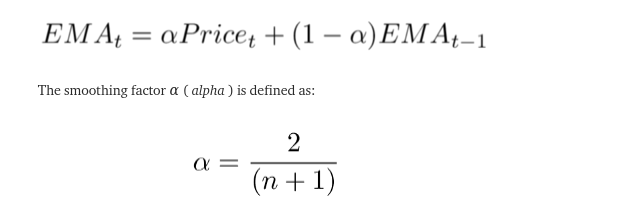

0.4338143917907204

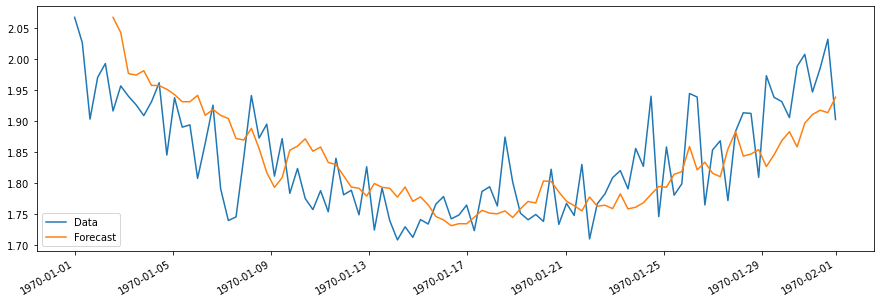

In [15]:
# Exponential moving average
data.plot()
res_ewa = data.shift(shifts).ewm(span=5).mean()
res_ewa.plot(figsize=(15,5))

plt.legend(['Data','Forecast'])

sse(data, res_ewa)


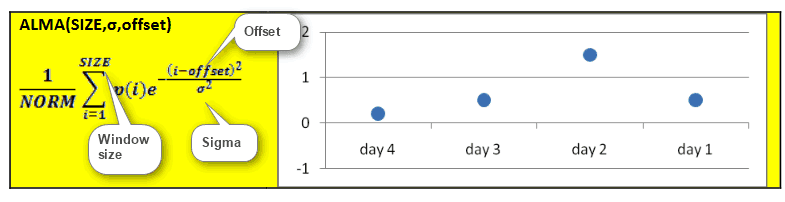

ALMA (Arnaud Legoux moving average) is a smoother typically used in the financial industry which aims to
    strike a good balance between smoothness and responsivness (i.e. capture a general smoothed trend without
    allowing for significant lag). It can be interpreted as a Gaussian weighted moving average with an
    offset, where the offset, spread and window size is user defined.

0.39783093295566624

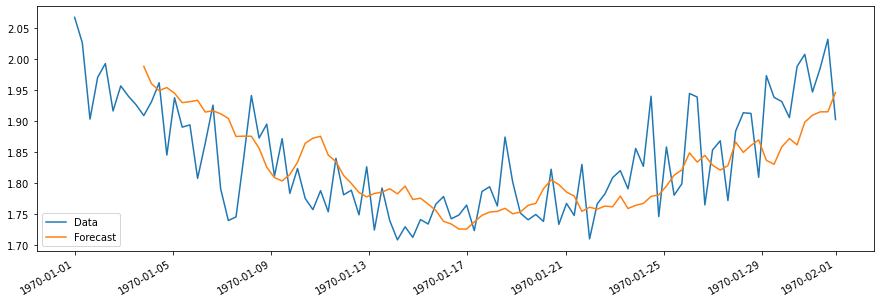

In [16]:
# Alma parameters
sigma = 6
offset_factor = 0.75
window = 5
offset = int(offset_factor * window)
k = np.array(range(0, window))
weights = np.exp(-((k - offset) ** 2) / (sigma ** 2))

def alma(x, weights):
    weighted_sum = weights *x
    alma = weighted_sum.sum() / weights.sum()
    return alma

res_alma  =data.shift(shifts).rolling(window=window).apply(lambda x: alma(x, weights))

data.plot()
res_alma.plot(figsize=(15,5))

plt.legend(['Data','Forecast'])

sse(data, res_alma)

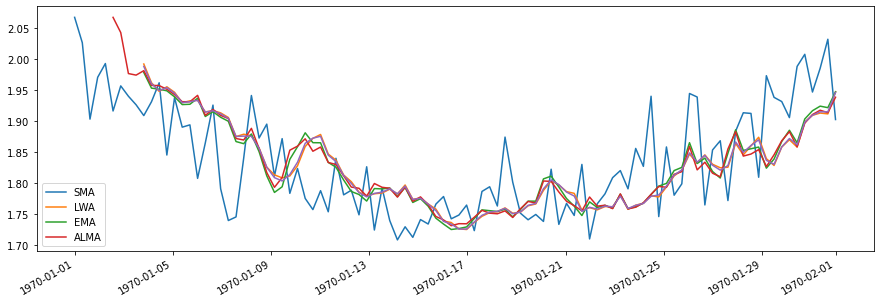

In [18]:
data.plot()
res_sma.plot()
res_lwa.plot(figsize=(15,5))
res_ewa.plot()
res_alma.plot()

plt.legend(['SMA','LWA','EMA','ALMA'])

# ARMA Models

Autoregressive moving averages

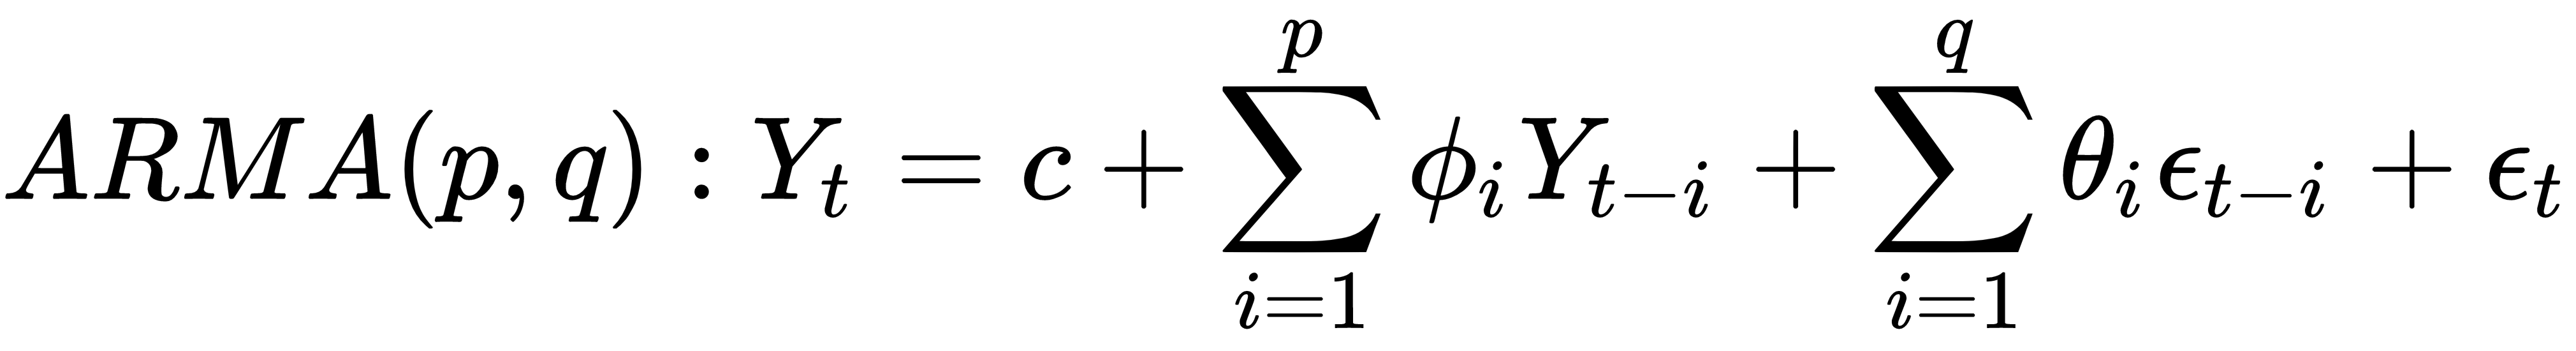

In [19]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")

def arma_predictor(
    data: pd.Series,
    ar_order: int = 2,
    ma_order: int = 2,
    train_test_split: float = 0.8,
    method: str = "onestep",
    steps: int = 1,
):
    """
    ARMA (Autoregressive Moving Average) predictor works by fitting constants to a ARMA parametric equation and extrapolating the results.
    Args:
        data (pd.Series): Data passed into function
        ar_order (int): Number of AR terms in the equation
        ma_order (int): Number of MA terms in the equation
        train_test_split (float): Fraction of the data defined into train and test sets.
        method (str): Type of prediction to perform; must be either 'multistep' or 'onestep'. The former involves forecasting several steps
                    ahead of the training dataset while the latter involves incrementally going through the test dataset, appending it to the training dataset
                    by performing a onestep forecast.
        steps (int): The number of steps to forecast ahead of the training dataset.
    Returns:
        pd.Series: Predicted data
    """

    # Check length of data
    if len(data) < 1:
        raise RuntimeError("No data passed to algorithm.")

    # Check integer arguments
    if type(ar_order) and type(ma_order) is not int:
        raise ValueError("AR order and MA order should be integers")

    # Check train-test split
    if not 0 < train_test_split < 1:
        raise ValueError("Alpha needs to be a float between 0 and 1")

    # Get key properties from data
    n_obs = len(data)
    n_train = int(n_obs * train_test_split)
    dt_step_sec = data.reset_index()["index"].diff().apply(lambda x: x.total_seconds()).mean()

    # If method is multistep, then simply forecast some steps ahead of training dataset
    if method == "multistep":
        train_data = data.iloc[:n_train]
        pred_data = train_and_return_forecast(ar_order, ma_order, train_data, steps, dt_step_sec)

    # If method is onestep, then iterate through test dataset and perform a one step prediction
    elif method == "onestep":

        # Storage array
        store_forecast = []

        # Limiting number of cycles to 100
        cycles = min(n_obs - n_train, 100)

        for it in range(cycles + 1):

            # Append new observation
            train_data = data.iloc[it : it + n_train]
            res = train_and_return_forecast(ar_order, ma_order, train_data, steps, dt_step_sec)
            store_forecast.append(res.tail(1))

        # Concatenate prediction dataframe
        pred_data = pd.concat(store_forecast)

    # If neither method, then raise value error
    else:
        raise ValueError(f"Method needs to be either 'onestep' or 'multistep'. Got {method}")

    # Return the prediction dataframe
    return pred_data.dropna()


def train_and_return_forecast(ar_order: int, ma_order: int, train_data: pd.Series, steps: int, dt_step_sec: int):
    """
    Function to train an ARMA model and return the forecasted value as a Pandas series with a datetime index
    Args:
        ar_order (int): Number of AR terms in the equation
        ma_order (int): Number of MA terms in the equation
        train_data (pd.Series): data to train model on
        steps (int): number of steps to forecast ahead of training data
        dt_step_sec (int): expected granularity for each step (seconds)
    """

    # Fit ARMA model
    model = ARIMA(train_data, order=(ar_order, 0, ma_order))
    fit_model = model.fit()

    # Perform prediction and return series with datetime index
    y_pred = fit_model.forecast(steps=steps).values
    max_dt = train_data.index[-1]
    dt_index = [max_dt + pd.Timedelta(seconds=it * dt_step_sec) for it in range(1, steps + 1)]
    return pd.Series(y_pred, index=dt_index)
 

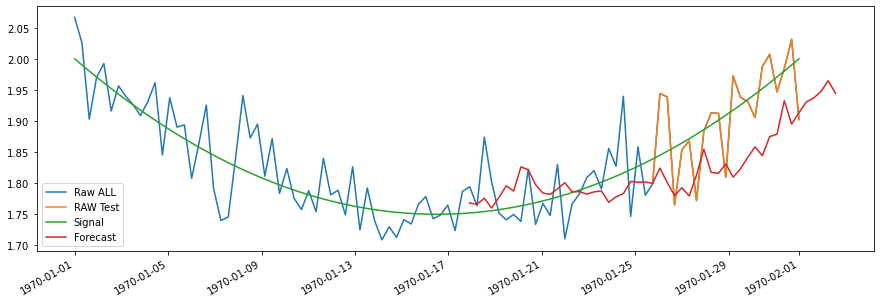

In [20]:
res = arma_predictor(data, steps=shifts, method='onestep',train_test_split=0.5, ar_order = 2, ma_order=2)

data.plot()
test_data.plot(figsize=(15,5))
perfect_data.plot()
res.plot()
plt.legend(['Raw ALL','RAW Test','Signal','Forecast'])

In [21]:
print(sum((data.iloc[49:].values - res.values) ** 2))

0.13043166397029307


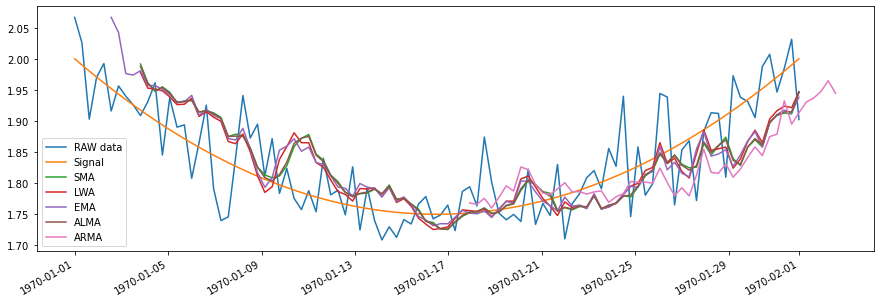

In [22]:
data.plot()
perfect_data.plot()
res_sma.plot()
res_lwa.plot(figsize=(15,5))
res_ewa.plot()
res_alma.plot()
res.plot()

plt.legend(['RAW data','Signal','SMA','LWA','EMA','ALMA','ARMA'])

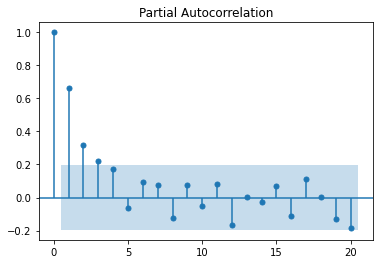

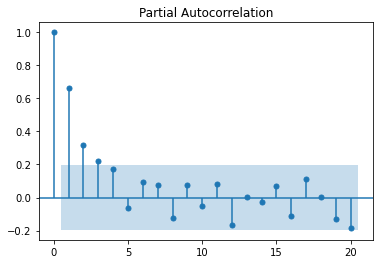

In [30]:
# Choosing the right AR coefficients
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plot_pacf(data)


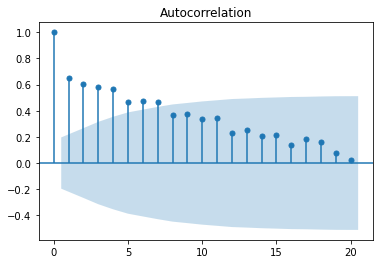

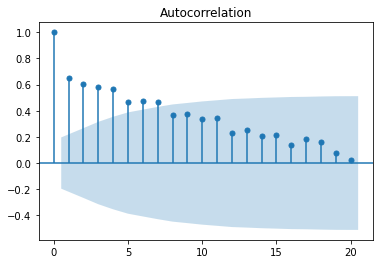

In [31]:
# Choosing MA
plot_acf(data)

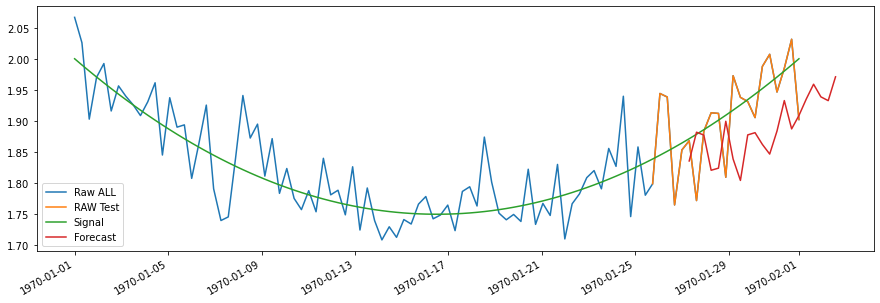

In [36]:
res = arma_predictor(data, steps=shifts, method='onestep',train_test_split=0.8, ar_order = 4, ma_order=8)

data.plot()
test_data.plot(figsize=(15,5))
perfect_data.plot()
res.plot()
plt.legend(['Raw ALL','RAW Test','Signal','Forecast'])

In [37]:
print(sum((data.iloc[79:].values - res.values) ** 2))

0.07692350431524332


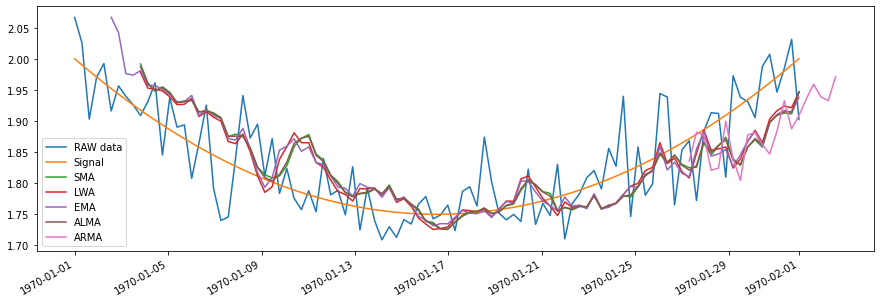

In [38]:
data.plot()
perfect_data.plot()
res_sma.plot()
res_lwa.plot(figsize=(15,5))
res_ewa.plot()
res_alma.plot()
res.plot()

plt.legend(['RAW data','Signal','SMA','LWA','EMA','ALMA','ARMA'])